In [1]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
h5s = []
raw_h5s = []
for f in os.listdir('KumarDatasets'):
    h5 = sc.read_h5ad(f'KumarDatasets/{f}')
    h5 = h5[h5.obs['nCount_Spatial'].dropna().index]
    raw_h5s.append(h5.copy())
    sc.pp.normalize_total(h5, exclude_highly_expressed = True)
    h5s.append(h5)

C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to

In [3]:
for h5 in h5s:
    print(h5.obs['donor_id'].iloc[0])

P79
P82
P85
P46
P10
P127
P67
P47
P65
P35


In [4]:
metadata = [
    ['y', 'prophylatic masectomy', 1, 30.61, 'unknown'],
    ['y', 'reduction mammoplasty', 1, 45.46, 'none'],
    ['y', 'reduction mammoplasty', 1, 30.90, 'none'],
    ['y', 'reduction mammoplasty', 1, 42.51, 'none'],
    ['y', 'cancer masectomy', 1, 29.79, 'chemotherapy'],
    [None, None, None, None, None],
    ['y', 'reduction mammoplasty', 0, 25.89, 'none'],
    ['y', 'reduction mammoplasty', 1, 29.79, 'none'],
    ['y', 'reduction mammoplasty', 1, 41.46, 'none'],
    ['y', 'cancer mastectomy', 1, 24.71, 'chemotherapy']
]

metadata = pd.DataFrame(
    metadata,
    index = [h5.obs['donor_id'].iloc[0] for h5 in h5s],
    columns = ['age', 'source', 'parity', 'BMI', 'prior treatment']
)

In [5]:
metadata

age                 source  parity    BMI prior treatment
P79      y  prophylatic masectomy     1.0  30.61         unknown
P82      y  reduction mammoplasty     1.0  45.46            none
P85      y  reduction mammoplasty     1.0  30.90            none
P46      y  reduction mammoplasty     1.0  42.51            none
P10      y       cancer masectomy     1.0  29.79    chemotherapy
P127  None                   None     NaN    NaN            None
P67      y  reduction mammoplasty     0.0  25.89            none
P47      y  reduction mammoplasty     1.0  29.79            none
P65      y  reduction mammoplasty     1.0  41.46            none
P35      y      cancer mastectomy     1.0  24.71    chemotherapy

In [6]:
from FORECASTS import *
clf = FORECASTS()

C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
for h5 in h5s:
    h5_df = h5.to_df()
    h5_df.columns = h5.var['feature_name']
    
    h5.obs['probs'] = clf.classify(h5_df, n_jobs = 8, logarithmized = False, verbose = False, normalized = True)
    h5.obs['preds'] = (h5.obs['probs'] > 0.584).astype(int)

In [9]:
cell_types = h5s[0].obs['author_cell_type'].unique()

for c in cell_types:
    per_h5 = []
    for A in h5s:
        subset = A[A.obs['author_cell_type'] == c]
        proportion = subset[subset.obs['preds'] == 1].X.sum() / subset.X.sum()
        per_h5.append(proportion)

    metadata[c] = per_h5

In [10]:
metadata

age                 source  parity    BMI prior treatment  ST3-Fibro  \
P79      y  prophylatic masectomy     1.0  30.61         unknown   0.491525   
P82      y  reduction mammoplasty     1.0  45.46            none   0.244186   
P85      y  reduction mammoplasty     1.0  30.90            none   0.674086   
P46      y  reduction mammoplasty     1.0  42.51            none   0.126984   
P10      y       cancer masectomy     1.0  29.79    chemotherapy   0.293233   
P127  None                   None     NaN    NaN            None   0.446991   
P67      y  reduction mammoplasty     0.0  25.89            none   0.322067   
P47      y  reduction mammoplasty     1.0  29.79            none   0.208443   
P65      y  reduction mammoplasty     1.0  41.46            none   0.323194   
P35      y      cancer mastectomy     1.0  24.71    chemotherapy   0.174312   

      ST1-Adipo     ST2-B  ST7-Lymphatic  ST5-LumSec  ST4-LumHR  ST9-Vascular  \
P79    0.574297  0.152125       0.330275    0.012987   0.074074      0.413534   
P82    0.164835  0.116684       0.175926    0.009901   0.007874      0.207729   
P85    0.354037  0.213665       0.503356    0.120459   0.000000      0.653062   
P46    0.053846  0.162526       0.101124    0.038889   0.116183      0.185484   
P10    0.243421  0.202880       0.301724    0.019231   0.069231      0.300000   
P127   0.402844  0.066964       0.444444    0.013274   0.000000      0.532111   
P67    0.290456  0.193015       0.252033    0.000000   0.012121      0.359447   
P47    0.092593  0.075758       0.175675    0.003205   0.035398      0.217557   
P65    0.081081  0.117108       0.288660    0.018692   0.086539      0.328572   
P35    0.252748  0.212230       0.255814    0.025000   0.157895      0.326733   

      ST6-LumSec/Basal  ST8-Vas/Peri  
P79           0.138462      0.617019  
P82           0.053254      0.672131  
P85           0.073171      0.688888  
P46           0.146199      0.354839  
P10           0.387597      0.686566  
P127          0.000000      0.777778  
P67           0.055556      0.793104  
P47           0.109756      0.440678  
P65           0.089820      0.500001  
P35           0.166667      0.527779

'P79'

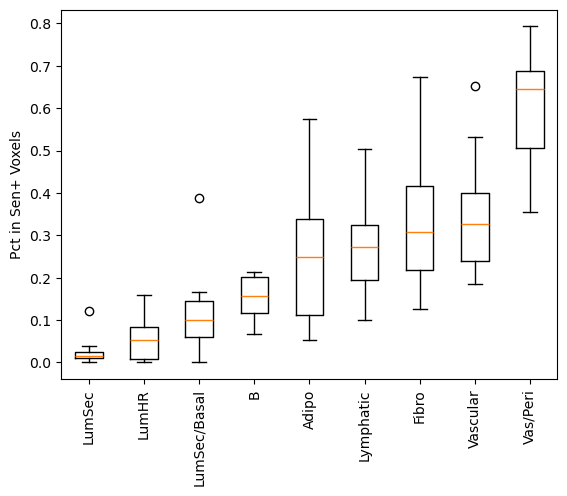

In [12]:
cell_type_proportions = metadata.iloc[:, 5:]
cell_type_proportions = cell_type_proportions.reindex(cell_type_proportions.mean().sort_values().index, axis = 1)

plt.boxplot(
    cell_type_proportions,
    labels = [x[4:] for x in cell_type_proportions.columns]
)

plt.xticks(rotation = 'vertical')
plt.ylabel('Pct in Sen+ Voxels')
plt.show()

In [40]:
h5s[0]

AnnData object with n_obs × n_vars = 2694 × 36406
    obs: 'in_tissue', 'array_row', 'array_col', 'mapped_reference_annotation', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'tissue_type', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'probs', 'preds'
    var: 'feature_is_filtered'

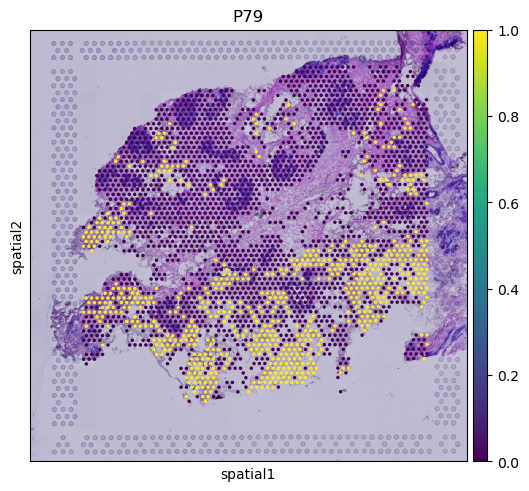

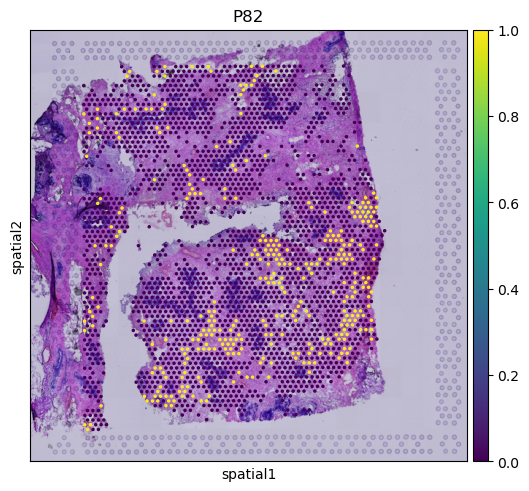

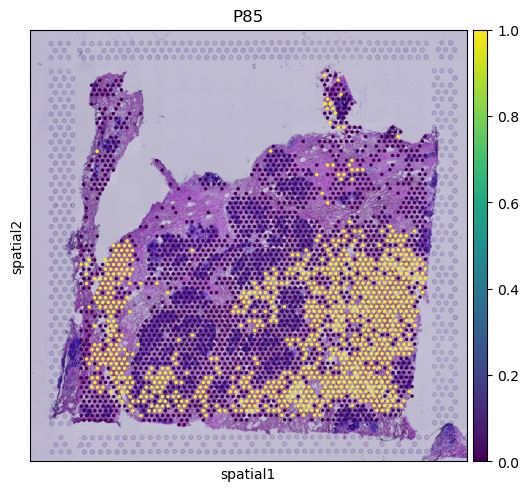

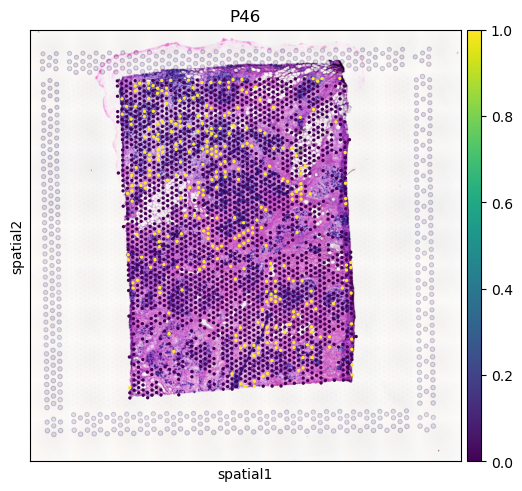

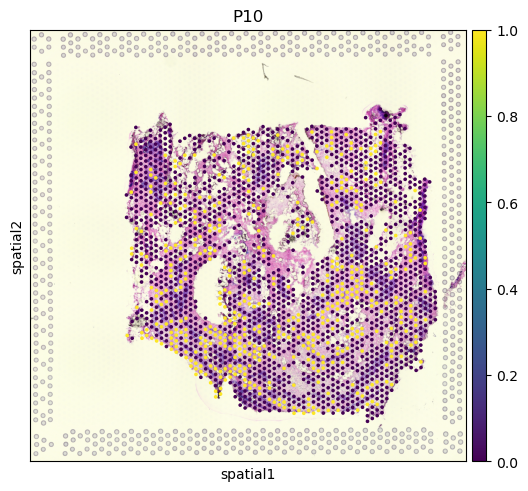

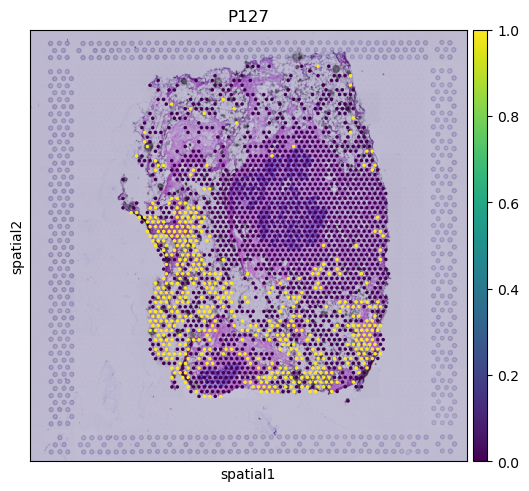

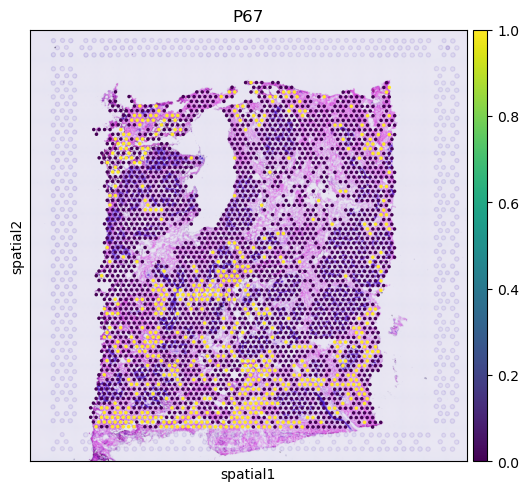

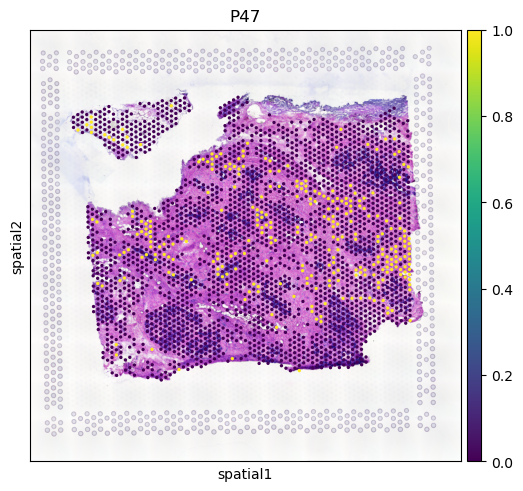

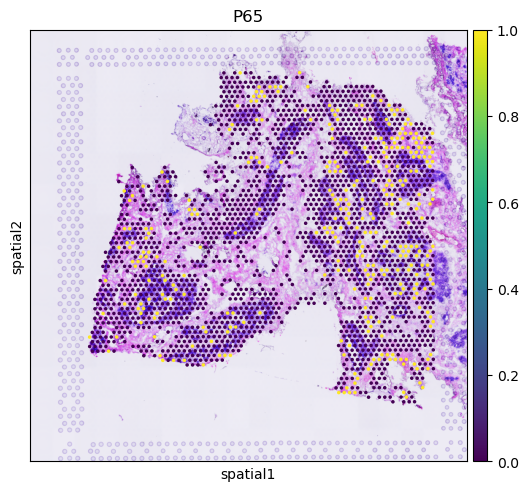

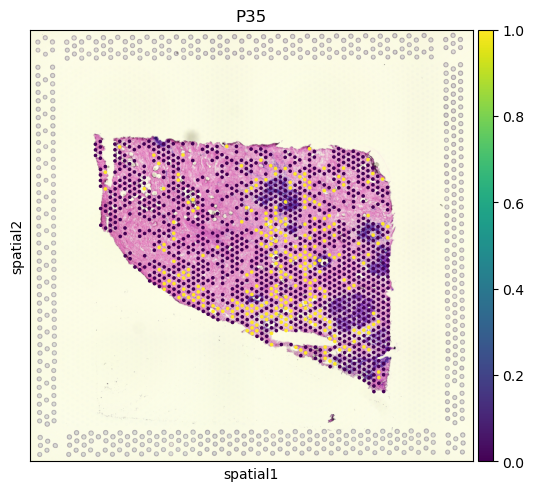

In [46]:
for i, A in enumerate(h5s):
    sq.pl.spatial_scatter(
        A,
        shape = 'circle', 
        color = 'preds', 
        library_id = list(A.uns['spatial'].keys())[0],
        title = metadata.iloc[i].name,
        save = f'kumar/{metadata.iloc[i].name}'
    )

In [ ]:
from scipy.stats import ttest_ind

for c in ctypes:
    pos = []
    neg = []
    
    for A in h5s:
        pos = pos + list(A.obs[(A.obs['author_cell_type'] == c) & (A.obs['preds'] == 1)]['nCount_Spatial'])
        neg = neg + list(A.obs[(A.obs['author_cell_type'] == c) & (A.obs['preds'] == 0)]['nCount_Spatial'])

    print(c)
    print(ttest_ind(pos, neg))
    plt.boxplot([pos, neg], labels = ['pos', 'neg'])
    plt.ylabel('num counts')
    plt.yscale('log')
    plt.show()

In [ ]:
neg

In [ ]:
this_h5.obs['nCount_Spatial']

In [ ]:
morans = []
for h5 in h5s:
    sq.gr.spatial_neighbors(h5)
    moran = sq.gr.spatial_autocorr(
        h5,
        mode = 'moran',
        genes = 'probs',
        n_perms = 100,
        attr = 'obs',
        copy = True,
        show_progress_bar = False,
        n_jobs = 8
    )
    morans.append(moran['I'].iloc[0])

metadata['morans'] = morans